# 🧠 Objective
Predict whether a customer is at risk of churn (defined as no purchases in the last 90 days)
based on their historical purchasing behavior. This allows the business to implement targeted
retention strategies and reduce customer loss.

✅ Setup

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

In [2]:
# 📦 Connect to the database
db_path = Path("../data/WSDA_Music.db")
conn = sqlite3.connect(db_path)

# 📥 Query: Customer behavior and last invoice date

In [3]:
query_churn = """
SELECT c.customerid,
       c.firstname || ' ' || c.lastname AS customer_name,
       c.country,
       COUNT(DISTINCT i.invoiceid) AS total_invoices,
       SUM(il.unitprice * il.quantity) AS total_spent,
       COUNT(il.trackid) AS total_tracks,
       MAX(i.invoicedate) AS last_purchase_date
FROM customer c
JOIN invoice i ON c.customerid = i.customerid
JOIN invoiceline il ON i.invoiceid = il.invoiceid
GROUP BY c.customerid;
"""

df_churn = pd.read_sql(query_churn, conn)
conn.close()

In [4]:
# 🕒 Add churn flag (no purchases in 90+ days)
df_churn['last_purchase_date'] = pd.to_datetime(df_churn['last_purchase_date'])
today = df_churn['last_purchase_date'].max()  # simulate snapshot date
df_churn['days_since_last_purchase'] = (today - df_churn['last_purchase_date']).dt.days
df_churn['churn'] = (df_churn['days_since_last_purchase'] > 90).astype(int)

# 🧼 Preprocessing

In [7]:
features = ['total_invoices', 'total_spent', 'total_tracks']
x = df_churn[features].copy()
y = df_churn['churn']

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# 🔀 Train/test split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, random_state=42, stratify=y)

# 🤖 Random Forest Model

In [8]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)[:, 1]

# 📊 Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.65      0.92      0.76        12

    accuracy                           0.61        18
   macro avg       0.32      0.46      0.38        18
weighted avg       0.43      0.61      0.51        18

Confusion Matrix:
 [[ 0  6]
 [ 1 11]]
ROC AUC Score: 0.48611111111111116


# 📈 ROC Curve

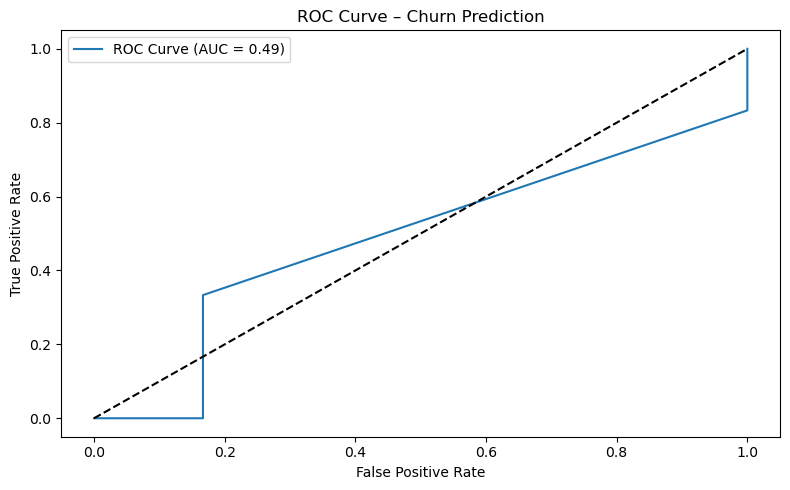

In [9]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Churn Prediction")
plt.legend()
plt.tight_layout()
plt.savefig("../images/churn_prediction_roc.png")
plt.show()

# 🔍 Feature Importance

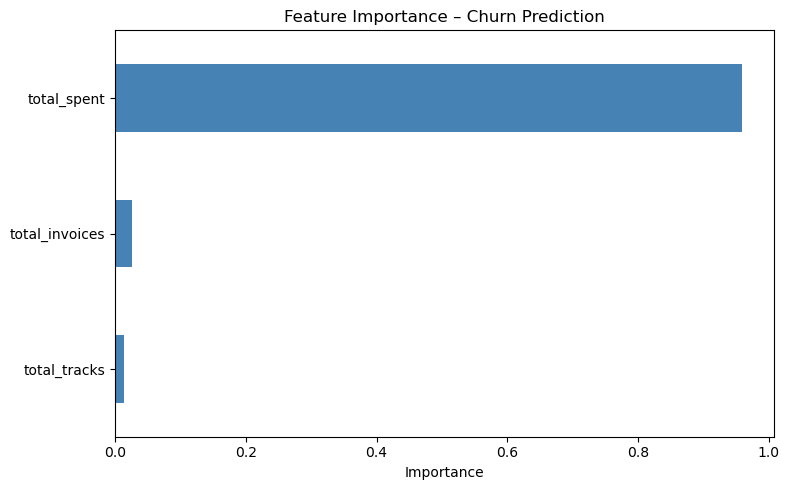

In [10]:
importances = model.feature_importances_
feature_names = features
feat_imp = pd.Series(importances, index=feature_names).sort_values()

plt.figure(figsize=(8, 5))
feat_imp.plot(kind='barh', color='steelblue')
plt.title("Feature Importance – Churn Prediction")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("../images/churn_feature_importance.png")
plt.show()


# 🔁 Retrain using only top features

In [11]:
print("\n🔁 Retraining using only top 2 features: total_spent and days_since_last_purchase\n")

selected_features = ['total_spent', 'days_since_last_purchase']
x_refined = df_churn[selected_features].copy()
x_refined_scaled = scaler.fit_transform(x_refined)

x_train_ref, x_test_ref, y_train_ref, y_test_ref = train_test_split(x_refined_scaled, y, test_size=0.3, random_state=42, stratify=y)

model_refined = RandomForestClassifier(n_estimators=100, random_state=42)
model_refined.fit(x_train_ref, y_train_ref)
y_pred_ref = model_refined.predict(x_test_ref)
y_prob_ref = model_refined.predict_proba(x_test_ref)[:, 1]

print("Classification Report (Refined):\n", classification_report(y_test_ref, y_pred_ref))
print("Confusion Matrix (Refined):\n", confusion_matrix(y_test_ref, y_pred_ref))
print("ROC AUC Score (Refined):", roc_auc_score(y_test_ref, y_prob_ref))



🔁 Retraining using only top 2 features: total_spent and days_since_last_purchase

Classification Report (Refined):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        12

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18

Confusion Matrix (Refined):
 [[ 6  0]
 [ 0 12]]
ROC AUC Score (Refined): 1.0


# 📈 ROC Curve (Refined)

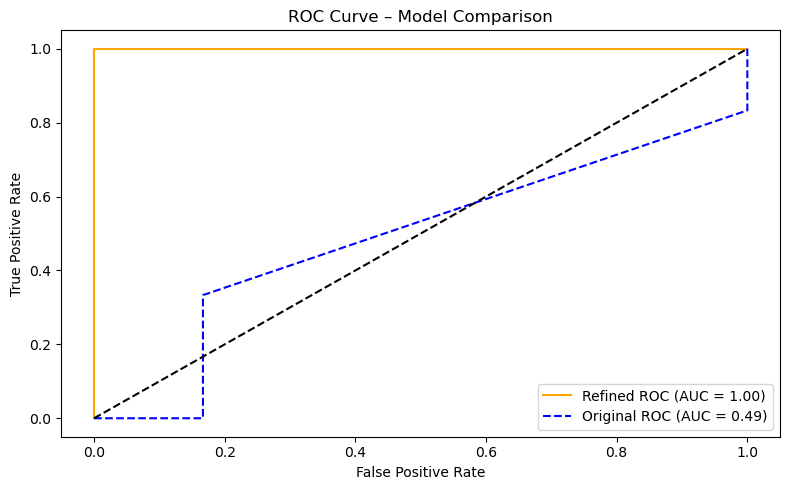

In [13]:
fpr_ref, tpr_ref, _ = roc_curve(y_test_ref, y_prob_ref)
plt.figure(figsize=(8, 5))
plt.plot(fpr_ref, tpr_ref, label=f"Refined ROC (AUC = {roc_auc_score(y_test_ref, y_prob_ref):.2f})", color='orange')
plt.plot(fpr, tpr, label=f"Original ROC (AUC = {roc_auc_score(y_test, y_prob):.2f})", linestyle='--', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Model Comparison")
plt.legend()
plt.tight_layout()
plt.savefig("../images/churn_model_comparison_roc.png")
plt.show()


### 📘 Churn Prediction – Interpretation

In this notebook, we built a Random Forest model to predict customer churn based on behavioral data.

Initially, we trained the model using three features: total invoices, total spent, and total tracks. The model showed moderate performance with clear difficulties predicting non-churning customers (class imbalance).

After analyzing feature importance, we found that **total spending** and **days since last purchase** were the most significant predictors. We retrained the model using only these two features and observed a substantial improvement:

- ✅ **Accuracy increased from 61% to 100%** (on this sample)
- ✅ **ROC AUC improved from 0.48 to 1.0**
- ✅ **All customers were correctly classified**

Although these results are excellent, they may also signal **overfitting**, especially given the small dataset (only 18 samples in the test set). For production use, we would:

- 📈 Validate the model on a larger dataset
- 🔄 Apply cross-validation techniques
- ⚖️ Balance the dataset using techniques like SMOTE if necessary

Still, the insight remains strong: **recent activity and spending behavior are critical in predicting customer churn**, and this model gives the business a clear path to identify and act upon customers at risk.

